In [ ]:
import sys

In [ ]:
file_path = "Phishing_Email.csv"

In [ ]:
! pip install pandas
import pandas as pd

In [ ]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib') 
pd.options.mode.chained_assignment = None

In [ ]:
dataset = pd.read_csv(file_path)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset.shape

In [ ]:
dataset.info()

In [ ]:
dataset.head(2)

In [ ]:
dataset.tail(2)

In [ ]:
dataset.sample(2) 

In [ ]:
dataset.dtypes

In [ ]:
unique_values = dataset.nunique()
print("Unique values in each column:")
print(unique_values)

In [ ]:
dataset['Email Type'].value_counts()

In [ ]:
dataset.isna().sum()

In [ ]:
dataset = dataset.dropna()

In [ ]:
dataset.shape

In [ ]:
dataset['Email Type'] = dataset['Email Type'].replace({
    'Safe Email': 0,
    'Phishing Email': 1
})


In [ ]:
dataset.to_csv("Phishing_Email_Processed.csv", index=False)

Separar del dataset un porcentaje para luego testearlo

In [ ]:
data = dataset.sample(frac=0.95, random_state=786)
data_indices = data.index
data = data.reset_index(drop=True)

In [ ]:
data_unseen = dataset.drop(data_indices)
data_unseen = data_unseen.reset_index(drop=True)

In [ ]:
!{sys.executable} -m pip install nltk
import nltk
from nltk.corpus import stopwords

Eliminar stopwords

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
def clean_text(text):
    tokens = text.lower().split()
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return ' '.join(tokens)

Reemplazar palabras por su abreviacion o sinomimo

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmer = WordNetLemmatizer()
def lematize(text):
    return ' '.join([lemmer.lemmatize(w) for w in text.split()])


Remove unicode, puntuations and HTTP tags

In [ ]:
import re
def remove_characters(text):
    t =  re.sub(r'[^\x00-\x7F]+',' ', text)
    t = re.sub(r'[^\w\s]', '', t)
    t = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",t)
    return t


Limpiar texto del email utilizando los metodos de arriba

In [ ]:
df = dataset
df['Cleaned'] = dataset['Email Text'].apply(clean_text)
df['Cleaned'] = df['Cleaned'].apply(remove_characters)
df['Cleaned'] = df['Cleaned'].apply(lematize)
df['Cleaned'] = df['Cleaned'].apply(clean_text)
df.to_csv("Phishing_Email_Cleaned.csv", index=False)
docs = df['Cleaned'].tolist()

In [28]:
!{sys.executable} -m pip install bertopic
from bertopic import BERTopic

  Using cached bertopic-0.17.0-py3-none-any.whl.metadata (23 kB)
  Using cached sentence_transformers-4.1.0-py3-none-any.whl.metadata (13 kB)
  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached huggingface_hub-0.33.0-py3-none-any.whl.metadata (14 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached hf_xet-1.1.5-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (879 bytes)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_

ModuleNotFoundError: No module named 'bertopic'

Entrenar modelo para predecir el topico de cual trata un texto

In [29]:
topic_model = BERTopic(language="english", calculate_probabilities=True)

NameError: name 'BERTopic' is not defined

In [ ]:
topics, probs = topic_model.fit_transform(docs)

In [ ]:
_topics, probs_unseen = topic_model.fit_transform(data_unseen['Email Text'].tolist())

NameError: name 'BERTopic' is not defined

Obtener topicos mas comunes, eliminando outliers si estan

In [ ]:
from collections import Counter

topic_counts = Counter(topics)

if -1 in topic_counts:
    del topic_counts[-1]

top_3_topics = [topic for topic, _ in topic_counts.most_common(3)]


Filtrar las probabilidades obtenidas limitandonos a esos topicos

In [ ]:
topic_cols = [f'Topic_{i}' for i in top_3_topics]

In [ ]:
probs_df = pd.DataFrame(probs, columns=[f'Topic_{i}' for i in range(probs.shape[1])])
filtered_probs_df = probs_df[topic_cols].copy()
filtered_probs_df['Dominant_Topic'] = filtered_probs_df[topic_cols].idxmax(axis=1)
filtered_probs_df['Perc_Dominant_Topic'] = filtered_probs_df[topic_cols].max(axis=1)

In [ ]:
probs_unseen_df = pd.DataFrame(probs, columns=[f'Topic_{i}' for i in range(probs.shape[1])])
filtered_probs_unseen_df = probs_unseen_df[topic_cols].copy()
filtered_probs_unseen_df['Dominant_Topic'] = filtered_probs_unseen_df[topic_cols].idxmax(axis=1)
filtered_probs_unseen_df['Perc_Dominant_Topic'] = filtered_probs_unseen_df[topic_cols].max(axis=1)

In [ ]:
dataset_p = pd.concat(
    [df[['Email Type', 'Email Text']].reset_index(drop=True), filtered_probs_df],
    axis=1
)


In [ ]:
data_unseen_p = pd.concat(
    [data_unseen[['Email Type', 'Email Text']].reset_index(drop=True), filtered_probs_unseen_df],
    axis=1
)

In [ ]:
dataset_p.to_csv("Phishing_Email_Processed.csv", index=False)

In [ ]:
data_unseen_p.to_csv("Phishing_Email_Unseen_Processed.csv", index=False)

In [ ]:
dataset_p.head()

Parte 3: Generar Modelo

In [4]:
!{sys.executable} -m pip install pycaret
from pycaret.classification import *

  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Using cached ipython-9.3.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached scipy-1.11.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (17 kB)
  Using cached pyod-2.0.5-py3-none-any.whl.metadata (46 kB)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached category_encoders-2.8.1-py3-none-any.whl.metadat

In [5]:
dataset = pd.read_csv("Phishing_Email_Processed.csv")

In [6]:
pce_1 = setup(data = dataset, target = 'Email Type', session_id = 5, train_size = 0.85) 

,Description,Value
0,Session id,5
1,Target,Email Type
2,Target type,Binary
3,Original data shape,"(18634, 7)"
4,Transformed data shape,"(18634, 9)"
5,Transformed train set shape,"(15838, 9)"
6,Transformed test set shape,"(2796, 9)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


In [7]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6482,0.6736,0.1308,0.8262,0.2256,0.1329,0.2286,0.3190
svm,SVM - Linear Kernel,0.6482,0.6325,0.1308,0.8262,0.2256,0.1329,0.2286,0.1410
ridge,Ridge Classifier,0.6482,0.6823,0.1308,0.8262,0.2256,0.1329,0.2286,0.1510
lda,Linear Discriminant Analysis,0.6482,0.6704,0.1308,0.8262,0.2256,0.1329,0.2286,0.1420
qda,Quadratic Discriminant Analysis,0.6481,0.6689,0.1310,0.8247,0.2258,0.1329,0.2281,0.1420
ada,Ada Boost Classifier,0.6474,0.5613,0.1253,0.8389,0.2179,0.1293,0.2280,0.1920
gbc,Gradient Boosting Classifier,0.6474,0.5559,0.1253,0.8393,0.2179,0.1293,0.2281,0.2900
et,Extra Trees Classifier,0.6465,0.6508,0.1215,0.8479,0.2123,0.1262,0.2271,0.1830
lightgbm,Light Gradient Boosting Machine,0.6465,0.5954,0.1197,0.8541,0.2098,0.1256,0.2279,225.5060
rf,Random Forest Classifier,0.6459,0.7233,0.1176,0.8540,0.2065,0.1236,0.2258,0.2150


In [8]:
print(best_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [9]:
import os
os.makedirs("./pkl", exist_ok=True)
save_model(best_model, './pkl/phishing_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Topic_0', 'Topic_1', 'Topic_2',
                                              'Perc_Dominant_Topic'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(ma

In [10]:
tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6528,0.6684,0.1353,0.8660,0.2340,0.1432,0.2479
1,0.6465,0.6766,0.1385,0.7748,0.2350,0.1317,0.2152
2,0.6604,0.6871,0.1594,0.8609,0.2690,0.1670,0.2687
3,0.6345,0.6914,0.0997,0.7654,0.1764,0.0944,0.1772
4,0.6458,0.6521,0.1270,0.8144,0.2197,0.1273,0.2206
5,0.6465,0.6668,0.1270,0.8229,0.2201,0.1285,0.2238
6,0.6540,0.6771,0.1415,0.8627,0.2431,0.1489,0.2525
7,0.6465,0.6606,0.1222,0.8444,0.2135,0.1268,0.2271
8,0.6475,0.6989,0.1320,0.8119,0.2271,0.1319,0.2243


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [11]:
print(tuned_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [12]:
save_model(tuned_model, './pkl/phishing_model_tuned')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Topic_0', 'Topic_1', 'Topic_2',
                                              'Perc_Dominant_Topic'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(ma

## Plots

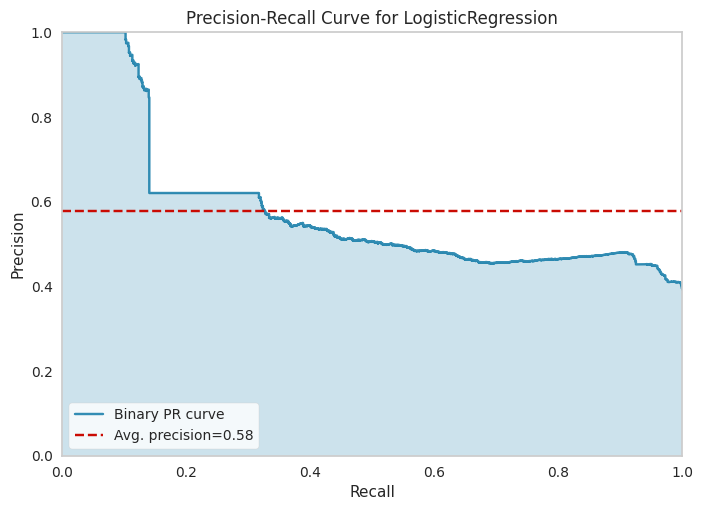

In [13]:
plot_model(tuned_model, plot = 'pr')

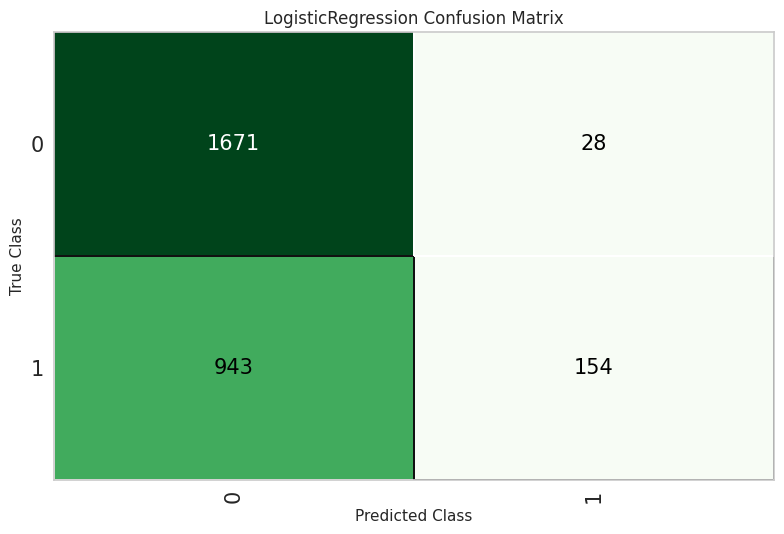

In [14]:
plot_model(tuned_model, plot='confusion_matrix')

## Predictions

In [15]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Predict on Test

In [16]:
predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6527,0.6647,0.1404,0.8462,0.2408,0.1454,0.2452


,Email Text,Topic_0,Topic_1,Topic_2,Dominant_Topic,Perc_Dominant_Topic,Email Type,prediction_label,prediction_score
10715,"URL: http://www.newsisfree.com/click/-5,856154...",0.000054,0.001158,0.000742,Topic_1,0.001158,0,0,0.6815
14627,"e - commerce & continental europe hi sven , th...",0.000380,0.001436,0.001089,Topic_1,0.001436,0,0,0.6817
6762,eol 4 / 12 / 01 fyi . . . - - - - - - - - - - ...,0.000240,0.001330,0.001164,Topic_1,0.001330,0,0,0.6816
1559,enron center south technology watch welcome to...,0.000200,0.001841,0.001541,Topic_1,0.001841,0,0,0.6818
330,philippe bibi we are disappointed to announce ...,0.000000,0.000000,0.000000,Topic_1,0.000000,0,0,0.6811
...,...,...,...,...,...,...,...,...,...
15419,\nLowest Viagra Prices Online!\nWe are the lar...,0.000694,0.001936,0.001852,Topic_1,0.001936,1,0,0.6819
10122,"enron / hpl actuals for september 21 , 2000 te...",0.000000,0.000000,0.000000,Topic_1,0.000000,0,0,0.6811
18280,"re : coastal o & g , mtr . 4179 , goliad co . ...",0.000377,0.001239,0.000962,Topic_1,0.001239,0,0,0.6816
10542,Welcome to Viagra Express!http://www.universal...,0.000585,0.001620,0.001548,Topic_1,0.001620,1,0,0.6817


Entrenamos el modelo sobre TODO el dataset de entrenamiento (incluyendo el holdout set). Sirve como paso final antes de hacer predicciones en datos nuevos reales o antes de guardar el modelo para producción.

In [17]:
final_model = finalize_model(tuned_model)

In [ ]:
final_model.named_steps["actual_estimator"]

In [18]:
save_model(final_model, './pkl/phishing_model_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Topic_0', 'Topic_1', 'Topic_2',
                                              'Perc_Dominant_Topic'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(ma

## Predict on Unseen data

In [26]:
unseen_predictions = predict_model(final_model, data=data_unseen)
unseen_predictions.head()

KeyError: "['Topic_0', 'Topic_1', 'Topic_2', 'Dominant_Topic', 'Perc_Dominant_Topic'] not in index"

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
y_true = unseen_predictions['Email Type']
y_pred = unseen_predictions['prediction_label']

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
